# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.construct import random
import seaborn as sns
import pandas as pd
import requests
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

seed=1337

## Import Data

In [2]:
def fetch_OEC_data(data_url="https://raw.githubusercontent.com/OpenExoplanetCatalogue/oec_tables/master/comma_separated/open_exoplanet_catalogue.txt",
                   dir_path=os.path.join("datasets", "OEC")):
    '''
    Downloads the current version of the Open Exoplanet Catalog
    from github and creates a directory to store the csv file. It
    returns the data as a pandas dataframe.
    ---------------------------------------
    INPUTS: data_url = The url to fetch the data from
            dir_path = The directory to save the csv file.
    OUTPUTS: Pandas.DataFrame()
    ---------------------------------------
    Columns names are based on the documentation provided
    at https://github.com/OpenExoplanetCatalogue/oec_tables.
    The names of the planets are used as indeces of the dataframe.
    '''
    
    os.makedirs(dir_path, exist_ok=True)
    data_path = os.path.join(dir_path, "oec.csv")
    r = requests.get(data_url)
    with open(data_path, "wb") as f:
        f.write(r.content)
    columns = [
        "Identifier", 
        "BinaryFlag",
        "MassJpt", 
        "RadiusJpt", 
        "PeriodDays", 
        "SemiMajorAxisAU",
        "Eccentricity", 
        "PeriastronDeg", 
        "LongitudeDeg", 
        "AscendingNodeDeg", 
        "InclinationDeg", 
        "EquilibriumTempK", 
        "AgeGyr", 
        "DiscoveryMethod", 
        "DiscoveryYear", 
        "LastUpdated", 
        "RA", 
        "Dec", 
        "DistParsec", 
        "StarMass", 
        "StarRadius", 
        "StarMetallicity", 
        "StarTempK", 
        "StarAgeGyr", 
        "ListPlanetIsOn"]
    return pd.read_csv(data_path, delimiter=',', skiprows=31, names=columns, index_col=0)

In [3]:
def prepare_data(df):
    '''
    Prepares the dataframe for the regressor. It does so by either
    dropping features that don't contain useful information for
    the regressor, or are not physically motivated. It also calculates
    the equilibrium temperature of planets that have the necessary
    information, and fills the missing values of the 'EquilibriumTempK'
    feature. Finally it calculates the stellar luminosity of the star
    of each system and appends the feature column to the rest of the
    dataframe.
    ---------------------------------------
    INPUTS: df = pandas.DataFrame The OEC dataframe
    OUTPUTS: df = pandas.DataFrame The processed OEC dataframe 
    ---------------------------------------

    Columns names are based on the documentation provided
    at https://github.com/OpenExoplanetCatalogue/oec_tables
    '''

    df.loc[df['ListPlanetIsOn'] == 'Confirmed planets']
    df = df.drop([
        'BinaryFlag', 
        'DiscoveryMethod', 
        'DiscoveryYear', 
        'LastUpdated', 
        'RA', 
        'Dec', 
        'DistParsec', 
        'ListPlanetIsOn', 
        'PeriastronDeg', 
        'LongitudeDeg', 
        'AscendingNodeDeg',
        'AgeGyr',
        'InclinationDeg', 
        'StarAgeGyr'],
        axis=1,
        )
    # Kelvins
    df["EquilibriumTempK"] = df["EquilibriumTempK"].fillna((df["StarRadius"]*0.00465047/(2*df["SemiMajorAxisAU"]))**(1/2)*df["StarTempK"]/(1-df["Eccentricity"]**2)**(1/8))
    # Solar luminosities
    df.insert(len(df.columns), "StarLuminosity", 4*np.pi*(df["StarRadius"]*6.957E+8)**2*5.670374419E-8*df["StarTempK"]**4/(3.848E+26))
    # We drop any planets that have missing values
    df = df.dropna(axis=0, how="any")
    return df

In [4]:
def prepare_data_mass_only(df):
    '''
    Prepares the dataframe for the regressor. It does so by either
    dropping features that don't contain useful information for
    the regressor, or are not physically motivated. It also calculates
    the equilibrium temperature of planets that have the necessary
    information, and fills the missing values of the 'EquilibriumTempK'
    feature. Finally it calculates the stellar luminosity of the star
    of each system and appends the feature column to the rest of the
    dataframe.
    ---------------------------------------
    INPUTS: df = The OEC dataframe.
    OUTPUTS: df = The processed OEC dataframe.
    ---------------------------------------

    Columns names are based on the documentation provided
    at https://github.com/OpenExoplanetCatalogue/oec_tables
    '''

    # Use only Confirmed Planets
    df.loc[df['ListPlanetIsOn'] == 'Confirmed planets']
    # Remove 
    df = df.drop([
        'BinaryFlag', 
        'DiscoveryMethod', 
        'DiscoveryYear', 
        'LastUpdated', 
        'RA', 
        'Dec', 
        'DistParsec', 
        'ListPlanetIsOn', 
        'PeriastronDeg', 
        'LongitudeDeg', 
        'AscendingNodeDeg',
        'AgeGyr',
        'InclinationDeg', 
        'StarAgeGyr'],
        axis=1)
    # Kelvins
    df["EquilibriumTempK"] = df["EquilibriumTempK"].fillna((df["StarRadius"]*0.00465047/(2*df["SemiMajorAxisAU"]))**(1/2)*df["StarTempK"]/(1-df["Eccentricity"]**2)**(1/8))
    # Solar luminosities
    df.insert(len(df.columns), "StarLuminosity", 4*np.pi*(df["StarRadius"]*6.957E+8)**2*5.670374419E-8*df["StarTempK"]**4/(3.848E+26))
    # We drop any planets that have missing values
    df = df[['MassJpt', 'RadiusJpt']].dropna(axis=0, how="any")
    return df

## Helper Functions

In [5]:
def split(df):
    '''
    Creates a random split of the data to a training set and a test set.
    The split is 75-25.
    ---------------------------------------
    INPUTS: df = pandas.DataFrame() The OEC dataframe
    OUTPUTS: X_train = numpy.ndarray() with shape (number of features
        other than radius, number of planets) containing the training
        set samples.
             y_train = numpy.ndarray() with shape (1,) containing the
        radius training labels
             X_test = numpy.ndarray() with shape (number of features
        other than radius, number of planets) containing the training
        set samples.
             y_test = numpy.ndarray() with shape (1,) containing the
        radius test labels
    ---------------------------------------
    '''
    X_train, X_test, y_train, y_test = train_test_split(
        df.loc[:, df.columns != 'RadiusJpt'].to_numpy(), 
        np.ravel(df["RadiusJpt"]),
        test_size=0.25, 
        shuffle=True, 
        random_state=seed)
    
    return X_train, y_train, X_test, y_test

def learning_curves(model, X, y):
    '''
    Creates the learning curves of our data and plots them.
    Returns the cv-scores for several different training set
    sizes.
    ---------------------------------------
    INPUTS: model = Sklearn estimator object.
            X = np.ndarray() with the shape training data.
            y = np.ndarray() with the shape of the training data's labels.
    OUTPUTS: val_scores_mean = np.ndarray() containing the mean cross
            validation score of the model for each training set size.
    ---------------------------------------
    '''
    train_sizes, train_scores, valid_scores = learning_curve(
        model, 
        X, 
        y, 
        train_sizes=np.linspace(0.1, 1.0, 8), 
        cv=5, 
        scoring='r2', 
        n_jobs=-1, 
        random_state=seed)
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(valid_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_std = np.std(valid_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, "r-o", linewidth=2, label="Training Score")
    plt.plot(train_sizes, val_scores_mean, "b-o", linewidth=3, label="Cross-Validation Score")
    plt.title(type(model).__name__)
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.legend()
    plt.xticks(train_sizes)
    return val_scores_mean

def evaluate(model, X_train, y_train):
    '''
    Creates a validation set composed of 25% of the training data
    to compute the RMSE of the estimator and stores it with the cv score
    computed from the learing_curves function to return them.
    ---------------------------------------
    INPUTS: model = Sklearn estimator object.
            X_train = np.ndarray() containing the training data.
            y = np.ndarray() containing the labels of the training data.
    OUTPUTS: scores = tuple containing the RMSE and cv scores.
    ---------------------------------------
    '''
    X_val, y_val = X_train[int(len(X_train)*75/100):,:], y_train[int(len(X_train)*75/100):]
    cv_score = learning_curves(model, X_train, y_train)
    y_predict = model.predict(X_val)
    RMSE = mean_squared_error(y_val, y_predict, squared=False)
    scores = RMSE, cv_score
    return scores

In [13]:
def printScores(RMSE_val, cv, r2, RMSE):
    print('Validation set RMSE:', RMSE_val)
    print('CV score:', cv)
    print('Test set R2 score:', r2)
    print('Test set RMSE:', RMSE)

## Ensemble Methods

In [6]:
def decision_tree_regressor(dataset, fit=False, scores=False, plot=False):
    '''
    CART based decision trees regression algorithm. If the necessery input
    parameters are provided it is able to optimize the model using 
    RandomizedSearchCV and GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    if fit==True:
        dt = DecisionTreeRegressor()
        # RandomSerchCV
        random_grid = {'max_features': np.arange(0.1, 11, 0.1)}
        dt_random = RandomizedSearchCV(
            estimator = dt, 
            scoring='r2', 
            param_distributions=random_grid, 
            n_iter=100, 
            cv=5, 
            verbose=2, 
            n_jobs=-1)
        dt_random.fit(X_train, y_train)

        # GridSearchCV
        grid = dt_random.best_params_.copy()
        grid['max_features'] = np.arange(grid['max_features']-1,grid['max_features']+1,1)
        grid['max_depth'] = np.arange(10, 100, 10)
        grid['min_samples_split'] = np.arange(2,11)
        grid['min_samples_leaf'] = np.arange(1,5)
        grid_search = GridSearchCV(
            estimator = dt, 
            scoring='r2', 
            param_grid=grid, 
            cv=3, 
            verbose=2, 
            n_jobs=-1)
        grid_search.fit(X_train, y_train)
        grid_search.best_params_['random_state'] = seed
        model = DecisionTreeRegressor(**grid_search.best_params_)
        model.fit(X_train, y_train)
    else:
        model = DecisionTreeRegressor(random_state=seed)
        model.fit(X_train, y_train)

    if plot==True:
        y_predict = model.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(model).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[:, 0], y=y_predict, hue=X_train[:, 4], palette='RdBu_r', edgecolor=None)
        norm = plt.Normalize(X_train[:, 4].min(), X_train[:, 4].max())
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        mr.get_legend().remove()
        mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()

    if scores==True:
        evaluation_scores = evaluate(model, X_train, y_train)
        return model, evaluation_scores[0] , evaluation_scores[1], r2_score(y_test, model.predict(X_test)), mean_squared_error(y_test, model.predict(X_test), squared=False)
    else:
        return model

def random_forest_regressor(dataset, fit=False, scores=False, plot=False):
    '''
    Random Forest ensemble method utilizing CART based decision trees regression algorithms. 
    If the necessery input parameters are provided it is able to optimize the model using 
    RandomizedSearchCV and GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    if fit==True:
        rf = RandomForestRegressor()
        # RandomSerchCV
        random_grid = {
            'n_estimators': np.arange(100, 1000, 10),
            'max_depth': np.arange(10, 100, 10),
            'max_features': np.arange(0.1, 10, 0.1),
            'min_samples_split': np.arange(2,11),
            'min_samples_leaf': np.arange(1,5)}
        rf_random = RandomizedSearchCV(
            estimator = rf, 
            scoring='r2', 
            param_distributions=random_grid, 
            n_iter = 300, 
            cv=3, 
            verbose=2, 
            n_jobs=-1)
        rf_random.fit(X_train, y_train)

        #GridSearchCV
        grid = rf_random.best_params_.copy()
        grid['n_estimators'] = np.linspace(grid['n_estimators']-10, grid['n_estimators']+10, 10, dtype=int)
        grid['max_depth'] = np.linspace(grid['max_depth']-10, grid['max_depth']+10, 10, dtype=int)
        grid['min_samples_split'] = [grid['min_samples_split']]
        grid['min_samples_leaf'] = [grid['min_samples_leaf']]
        grid['max_features'] = np.linspace(grid['max_features']-1, grid['max_features']+1, 3)
        grid_search = GridSearchCV(
            estimator = rf, 
            scoring='r2', 
            param_grid=grid, 
            cv=3, 
            verbose=2, 
            n_jobs=-1)
        grid_search.fit(X_train, y_train)
        grid_search.best_params_['random_state'] = seed
        model = RandomForestRegressor(**grid_search.best_params_)
        model.fit(X_train, y_train)
    else:
        model = RandomForestRegressor(random_state=seed)
        model.fit(X_train, y_train)

    if plot==True:
        y_predict = model.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(model).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[:, 0], y=y_predict, hue=X_train[:, 4], palette='RdBu_r', edgecolor=None)
        norm = plt.Normalize(X_train[:, 4].min(), X_train[:, 4].max())
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        mr.get_legend().remove()
        mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()

    if scores==True:
        evaluation_scores = evaluate(model, X_train, y_train)
        return model, evaluation_scores[0] , evaluation_scores[1], r2_score(y_test, model.predict(X_test)), mean_squared_error(y_test, model.predict(X_test), squared=False)
    else:
        return model

def extra_trees_regressor(dataset, fit=False, scores=False, plot=False):
    '''
    Extra Trees ensemble method utilizing CART based decision trees regression algorithms. 
    If the necessery input parameters are provided it is able to optimize the model using 
    GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    if fit==True:
        et = ExtraTreesRegressor()
        #GridSearchCV
        grid = {
            'n_estimators': np.arange(10, 110, 10),
            'max_depth': [1, 5, 10, 20], # Limited max depth to prevent overfitting
            'max_features': [1, 2, 3, 4, 5, 6],
            'min_impurity_decrease': [0.0001, 0.001, 0.01, 0.1, 0],
            'bootstrap': [True]}
        grid_search = GridSearchCV(
            estimator = et, 
            scoring='r2', 
            param_grid=grid, 
            cv=3, 
            verbose=2, 
            n_jobs=-1)
        grid_search.fit(X_train, y_train)
        grid_search.best_params_['random_state'] = seed
        model = ExtraTreesRegressor(**grid_search.best_params_)
        model.fit(X_train, y_train)
    else:
        model = ExtraTreesRegressor(bootstrap=True, random_state=seed)
        model.fit(X_train, y_train)

    if plot==True:
        y_predict = model.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(model).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[:, 0], y=y_predict, hue=X_train[:, 4], palette='RdBu_r', edgecolor=None)
        norm = plt.Normalize(X_train[:, 4].min(), X_train[:, 4].max())
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        mr.get_legend().remove()
        mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()

    if scores==True:
        evaluation_scores = evaluate(model, X_train, y_train)
        return model, evaluation_scores[0] , evaluation_scores[1], r2_score(y_test, model.predict(X_test)), mean_squared_error(y_test, model.predict(X_test), squared=False)
    else:
        return model

def adaboost(dataset, base_model, fit=False, scores=False, plot=False):
    '''
    AdaBoost algorithm that performs adaptive boosting using base_model as the
    base estimator. If the necessery input parameters are provided it is able to 
    optimize the model using GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    if fit==True:
        ad = AdaBoostRegressor()
        #GridSearchCV
        grid = {
            'n_estimators': np.arange(10, 70, 10),
            'learning_rate': np.arange(0.1, 1.1, 0.1),
            'loss': ['linear', 'square', 'exponential'],
            'base_estimator': [base_model]
            }
        grid_search = GridSearchCV(
            estimator = ad, 
            scoring='r2', 
            param_grid=grid, 
            cv=3, 
            verbose=2, 
            n_jobs=-1)
        grid_search.fit(X_train, y_train)
        grid_search.best_params_['random_state'] = seed
        model = AdaBoostRegressor(**grid_search.best_params_)
        model.fit(X_train, y_train)
    else:
        model = AdaBoostRegressor(base_estimator=base_model, random_state=seed)
        model.fit(X_train, y_train)

    if plot==True:
        y_predict = model.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(model).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[:, 0], y=y_predict, hue=X_train[:, 4], palette='RdBu_r', edgecolor=None)
        norm = plt.Normalize(X_train[:, 4].min(), X_train[:, 4].max())
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        mr.get_legend().remove()
        mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()

    if scores==True:
        evaluation_scores = evaluate(model, X_train, y_train)
        return model, evaluation_scores[0] , evaluation_scores[1], r2_score(y_test, model.predict(X_test)), mean_squared_error(y_test, model.predict(X_test), squared=False)
    else:
        return model

def gradientboost(dataset, fit=False, scores=False, plot=False):
    '''
    Gradient Boosted Regression Tree algorithm that performs gradient boosting. 
    If the necessery input parameters are provided it is able to optimize the model using 
    RandomizedSearchCV and GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    if fit==True:
        gd = GradientBoostingRegressor()
        # RandomSerchCV
        random_grid = {
            'n_estimators': np.arange(10, 100, 10),
            'max_depth': np.linspace(1, 10, 4, dtype=int),
            'max_features': np.arange(0.1, 10, 0.1),
            'min_samples_split': np.arange(2,11),
            'min_samples_leaf': np.arange(1,5),
            'learning_rate': np.arange(0.1, 1.1, 0.1),
            'subsample': [0.1, 0.5, 1.0]}
        gd_random = RandomizedSearchCV(
            estimator = gd, 
            scoring='r2', 
            param_distributions=random_grid, 
            n_iter = 1000, 
            cv = 5, 
            verbose=2, 
            n_jobs=-1)
        gd_random.fit(X_train, y_train)

        #GridSearchCV
        grid = gd_random.best_params_.copy()
        grid['n_estimators'] = np.linspace(grid['n_estimators']-10, grid['n_estimators']+10, 10, dtype=int)
        grid['max_depth'] = np.linspace(grid['max_depth']-10, grid['max_depth']+10, 10, dtype=int)
        grid['min_samples_split'] = [grid['min_samples_split']]
        grid['min_samples_leaf'] = [grid['min_samples_leaf']]
        grid['max_features'] = np.linspace(grid['max_features']-1, grid['max_features']+1, 3)
        grid['subsample'] = [grid['subsample']]
        grid['learning_rate'] = [grid['learning_rate']]
        grid_search = GridSearchCV(
            estimator = gd, 
            scoring='r2', 
            param_grid=grid, 
            cv=10, 
            verbose=2, 
            n_jobs=-1)
        grid_search.fit(X_train, y_train)
        grid_search.best_params_['random_state'] = seed
        model = GradientBoostingRegressor(**grid_search.best_params_)
        model.fit(X_train, y_train)
    else:
        model = GradientBoostingRegressor(random_state=seed)
        model.fit(X_train, y_train)

    if plot==True:
        y_predict = model.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(model).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[:, 0], y=y_predict, hue=X_train[:, 4], palette='RdBu_r', edgecolor=None)
        norm = plt.Normalize(X_train[:, 4].min(), X_train[:, 4].max())
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        mr.get_legend().remove()
        mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()

    if scores==True:
        evaluation_scores = evaluate(model, X_train, y_train)
        return model, evaluation_scores[0] , evaluation_scores[1], r2_score(y_test, model.predict(X_test)), mean_squared_error(y_test, model.predict(X_test), squared=False)
    else:
        return model

# Regression Models with Regularization

In [7]:
def linridge(dataset, fit=False, scores=False, plot=False):
    '''
    Linear Ridge Regression model. If the necessery input parameters are provided 
    it is able to optimize the model using GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    if fit==True:
        dt = Ridge()
        # GridSearchCV
        grid = {'alpha': [0.01, 0.1, 1],
                'max_iter': np.arange(100,1000,100)}
        grid_search = GridSearchCV(
            estimator = dt, 
            scoring='r2', 
            param_grid=grid, 
            cv=3, 
            verbose=2, 
            n_jobs=-1)
        grid_search.fit(X_train, y_train)
        grid_search.best_params_['random_state'] = seed
        model = Ridge(**grid_search.best_params_)
        model.fit(X_train, y_train)
    else:
        model = Ridge(random_state=seed)
        model.fit(X_train, y_train)

    if plot==True:
        y_predict = model.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(model).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[:, 0], y=y_predict, hue=X_train[:, 4], palette='RdBu_r', edgecolor=None)
        norm = plt.Normalize(X_train[:, 4].min(), X_train[:, 4].max())
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        mr.get_legend().remove()
        mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        plt.ylim(0.001,5)
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()

    if scores==True:
        evaluation_scores = evaluate(model, X_train, y_train)
        return model, evaluation_scores[0] , evaluation_scores[1], r2_score(y_test, model.predict(X_test))
    else:
        return model
    
def linlasso(dataset, fit=False, scores=False, plot=False):
    '''
    Linear LASSO Regression model. If the necessery input parameters are provided 
    it is able to optimize the model using GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    if fit==True:
        dt = Lasso()
        # GridSearchCV
        grid = {'alpha': [0.001,0.01, 0.1, 1,10],
                'max_iter': np.arange(100,1000,100)}
        grid_search = GridSearchCV(
            estimator = dt, 
            scoring='r2', 
            param_grid=grid, 
            cv=3,
            verbose=2, 
            n_jobs=-1)
        grid_search.fit(X_train, y_train)
        grid_search.best_params_['random_state'] = seed
        grid_search.best_params_['selection'] = 'random'
        model = Lasso(**grid_search.best_params_)
        model.fit(X_train, y_train)
    else:
        model = Lasso(alpha=0.01,max_iter=100,random_state=seed)
        model.fit(X_train, y_train)

    if plot==True:
        y_predict = model.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(model).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[:, 0], y=y_predict, hue=X_train[:, 4], palette='RdBu_r', edgecolor=None)
        norm = plt.Normalize(X_train[:, 4].min(), X_train[:, 4].max())
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        mr.get_legend().remove()
        mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        plt.ylim(0.001,5)
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()

    if scores==True:
        evaluation_scores = evaluate(model, X_train, y_train)
        return model, evaluation_scores[0] , evaluation_scores[1], r2_score(y_test, model.predict(X_test))
    else:
        return model
    
def linelastic(dataset, fit=False, scores=False, plot=False):
    '''
    Linear Elastic Regression model. If the necessery input parameters are provided 
    it is able to optimize the model using GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    if fit==True:
        dt = ElasticNet()
        # GridSearchCV
        grid = {'alpha': [0.01, 0.1, 1, 10],
                'l1_ratio': np.arange(0,1,0.1),
                'max_iter': np.arange(100,1000,100)}
        grid_search = GridSearchCV(
            estimator = dt, 
            scoring='r2', 
            param_grid=grid, 
            cv=3, 
            verbose=2, 
            n_jobs=-1)
        grid_search.fit(X_train, y_train)
        grid_search.best_params_['random_state'] = seed
        grid_search.best_params_['selection'] = 'random'
        model = ElasticNet(**grid_search.best_params_)
        model.fit(X_train, y_train)
    else:
        model = ElasticNet(alpha=0.1,max_iter=100,l1_ratio=0.2,random_state=seed)
        model.fit(X_train, y_train)

    if plot==True:
        y_predict = model.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(model).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[:, 0], y=y_predict, hue=X_train[:, 4], palette='RdBu_r', edgecolor=None)
        norm = plt.Normalize(X_train[:, 4].min(), X_train[:, 4].max())
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        mr.get_legend().remove()
        mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        plt.ylim(0.001,5)
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()

    if scores==True:
        evaluation_scores = evaluate(model, X_train, y_train)
        return model, evaluation_scores[0] , evaluation_scores[1], r2_score(y_test, model.predict(X_test))
    else:
        return model
    
def polyridge(dataset, fit=False, scores=False, plot=False):
    '''
    Polynomial Ridge Regression model. If the necessery input parameters are provided 
    it is able to optimize the model using GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    if fit==True:
        dt = Ridge()
        # GridSearchCV
        grid = {'alpha': [ 1, 10, 100],
                'max_iter': np.arange(100,1000,100)}
        grid_search = GridSearchCV(
            estimator = dt, 
            scoring='r2', 
            param_grid=grid, 
            cv=10, 
            verbose=2, 
            n_jobs=-1)
        grid_search.fit(X_train, y_train)
        grid_search.best_params_['random_state'] = seed
        model = Ridge(**grid_search.best_params_)
        model= Pipeline([
                         ("poly_features",PolynomialFeatures(degree =2, include_bias = False)),
                         ("ridge", model)                            
        ])
        model.fit(X_train, y_train)
    else:
        model = Ridge(alpha=100, max_iter=100,random_state=seed)
        model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree =2, include_bias = False)),
                    ("ridge", model)
                ])
        model.fit(X_train, y_train)

    if plot==True:
        y_predict = model.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(model).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[:, 0], y=y_predict, hue=X_train[:, 4], palette='RdBu_r', edgecolor=None)
        norm = plt.Normalize(X_train[:, 4].min(), X_train[:, 4].max())
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        mr.get_legend().remove()
        mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        plt.ylim(0.001,5)
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()

    if scores==True:
        evaluation_scores = evaluate(model, X_train, y_train)
        return model, evaluation_scores[0] , evaluation_scores[1], r2_score(y_test, model.predict(X_test))
    else:
        return model
    
def polylasso(dataset, fit=False, scores=False, plot=False):
    '''
    Polynomial LASSO Regression model. If the necessery input parameters are provided 
    it is able to optimize the model using GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    if fit==True:
        dt = Lasso()
        # GridSearchCV
        grid = {'alpha': [1, 10, 100],
                'max_iter': np.arange(100,1000,100)}
        grid_search = GridSearchCV(
            estimator = dt, 
            scoring='r2', 
            param_grid=grid, 
            cv=10, 
            verbose=2, 
            n_jobs=-1)
        grid_search.fit(X_train, y_train)
        grid_search.best_params_['random_state'] = seed
        grid_search.best_params_['selection'] = 'random'
        model = Lasso(**grid_search.best_params_)
        model= Pipeline([
                         ("poly_features", PolynomialFeatures(degree=2,include_bias=False)),
                         ("lasso", model)
        ])
        model.fit(X_train, y_train)
    else:
        model = Lasso(max_iter=100,random_state=seed)
        model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree =2, include_bias = False)),
                    ("lasso", model)
                ])
        model.fit(X_train, y_train)

    if plot==True:
        y_predict = model.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(model).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[:, 0], y=y_predict, hue=X_train[:, 4], palette='RdBu_r', edgecolor=None)
        norm = plt.Normalize(X_train[:, 4].min(), X_train[:, 4].max())
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        mr.get_legend().remove()
        mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        plt.ylim(0.001,5)
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()

    if scores==True:
        evaluation_scores = evaluate(model, X_train, y_train)
        return model, evaluation_scores[0] , evaluation_scores[1], r2_score(y_test, model.predict(X_test))
    else:
        return model
    
def polyelastic(dataset, fit=False, scores=False, plot=False):
    '''
    Polynomial Elastic Regression model. If the necessery input parameters are provided 
    it is able to optimize the model using GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    X_train, y_train, X_test, y_test = split(dataset)
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    if fit==True:
        dt = ElasticNet()
        # GridSearchCV
        grid = {'alpha': [10, 100],
                'l1_ratio': np.arange(0,1,0.1),
                'max_iter': np.arange(100,1000,100)}
        grid_search = GridSearchCV(
            estimator = dt, 
            scoring='r2', 
            param_grid=grid, 
            cv=10, 
            verbose=2, 
            n_jobs=-1)
        grid_search.fit(X_train, y_train)
        grid_search.best_params_['random_state'] = seed
        grid_search.best_params_['selection'] = 'random'
        model = ElasticNet(**grid_search.best_params_)
        model= Pipeline ([
                          ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
                          ("elastic", model)
        ])
        model.fit(X_train, y_train)
    else:
        model = ElasticNet(l1_ratio=0.0,alpha=10,max_iter=100,random_state=seed)
        model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree =2, include_bias = False)),
                    ("elastic", model)
                ])
        model.fit(X_train, y_train)

    if plot==True:
        y_predict = model.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(model).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[:, 0], y=y_predict, hue=X_train[:, 4], palette='RdBu_r', edgecolor=None)
        norm = plt.Normalize(X_train[:, 4].min(), X_train[:, 4].max())
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        mr.get_legend().remove()
        mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        plt.ylim(0.001,5)
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()

    if scores==True:
        evaluation_scores = evaluate(model, X_train, y_train)
        return model, evaluation_scores[0] , evaluation_scores[1], r2_score(y_test, model.predict(X_test))
    else:
        return model

# SVM Models

In [8]:
#linear SVR
from sklearn.svm import LinearSVR
def linear_SVR(dataset, fit=False, scores=False, plot=False):
    '''
    Linear SVM regressor model. If the necessery input parameters are provided 
    it is able to optimize the model using GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    if fit==True:
        dt = LinearSVR()
              # GridSearchCV
        grid = {'C':np.append(np.linspace(1, 100, dtype=int),
                              [0.001, 0.01, 0.1]), 
                'epsilon': [0.001, 0.01, 0.1, 1, 10]
            }
        grid_search = GridSearchCV(
          estimator = dt, 
          scoring='r2', 
          param_grid=grid, 
          cv=5, 
          verbose=2, 
          n_jobs=-1)
        grid_search.fit(X_train, y_train)
        svm_reg =LinearSVR(**grid_search.best_params_)
        svm_reg.fit(X_train, y_train)
    else:
        svm_reg =LinearSVR()
        svm_reg.fit(X_train, y_train)
    #plots
    if plot==True:
        y_predict =svm_reg.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(svm_reg).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[0:, 0], y=y_predict, hue=X_train[0:, 4], palette='RdBu_r', edgecolor="none")
        norm = plt.Normalize(X_train[0:, 4].min(), X_train[0:, 4].max())
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        mr.get_legend().remove()
        mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()
    #learning curves
    if scores==True:
        RMSE_SVR, CV_SVR = evaluate(svm_reg, X_train, y_train)
        return svm_reg, RMSE_SVR, CV_SVR, r2_score(y_test, svm_reg.predict(X_test))
    else:
        return svm_reg

def poly_SVR(dataset, fit=False, scores=False, plot=False):
    '''
    Kernelized SVM regressor model with a polynomial kernel. If the necessery 
    input parameters are provided it is able to optimize the model using GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    if fit==True:
        dt =SVR()
              # GridSearchCV
        grid = {'C': np.arange(10, 210, 10), 
                'epsilon': [0.001, 0.01, 0.1, 1, 10],
                'kernel': ['poly'],
                'degree': [2,3]}
        grid_search = GridSearchCV(
          estimator = dt, 
          scoring='r2', 
          param_grid=grid, 
          cv=3, 
          verbose=2, 
          n_jobs=-1)
        grid_search.fit(X_train, y_train)
        svm_poly_reg =SVR(**grid_search.best_params_)
        svm_poly_reg.fit(X_train, y_train) 
    else:
        svm_poly_reg = SVR(C=200, degree=2, epsilon=0.01)
        svm_poly_reg.fit(X_train, y_train) 
    #plots
    if plot==True:
        y_predict =svm_poly_reg.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(svm_poly_reg).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[0:, 0], y=y_predict, palette='RdBu_r', edgecolor="none")
        mr.set(xscale="log", yscale="log")
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()
    if scores==True:
        #learning curves
        RMSE_SVR, CV_SVR = evaluate(svm_poly_reg, X_train, y_train)
        return svm_poly_reg, RMSE_SVR, CV_SVR, r2_score(y_test, svm_poly_reg.predict(X_test))
    else:
        return svm_poly_reg

def gauss_SVR(dataset, fit=False, scores=False, plot=False):
    '''
    Kernelized SVM regressor model with aN RBF kernel. If the necessery 
    input parameters are provided it is able to optimize the model using GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    if fit==True:
        dt =SVR()
        # GridSearchCV
        grid = {
          'C': [0.01, 0.1, 1, 10, 100],
          'kernel': ['rbf'] ,
          'gamma': [0.001, 0.01, 0.1, 1], 
          'epsilon': np.linspace(0.001, 0.1, 100)
        }
        grid_search = GridSearchCV(
          estimator = dt, 
          scoring='r2', 
          param_grid=grid, 
          cv=3, 
          verbose=2, 
          n_jobs=-1)
        grid_search.fit(X_train, y_train)
        rbf_kernel_svr =SVR(**grid_search.best_params_)
        rbf_kernel_svr.fit(X_train, y_train)
    else:
        rbf_kernel_svr =SVR(C=100, gamma=0.1, epsilon=0.01, kernel='rbf')
        rbf_kernel_svr.fit(X_train, y_train)
    #plots
    if plot==True:
        y_predict =rbf_kernel_svr.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        truevspred.set_xlim(0, 2.15)
        truevspred.set_ylim(0.3, 1.175)
        plt.title(type(rbf_kernel_svr).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train.flatten(), y=y_predict,palette='RdBu_r', edgecolor="none")
        mr.set(xscale="log", yscale="log")
        mr.set(xlabel=r"Normalised Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()
    if scores==True:
    #learning curves
        RMSE_SVR, CV_SVR = evaluate(rbf_kernel_svr, X_train, y_train, X_test, y_test)
        return rbf_kernel_svr, RMSE_SVR, CV_SVR, r2_score(y_test, rbf_kernel_svr.predict(X_test))
    else:
        return rbf_kernel_svr
    
def sigmoid_SVR(dataset, fit=False, scores=False, plot=False):
    '''
    Kernelized SVM regressor model with a sigmoid kernel. If the necessery 
    input parameters are provided it is able to optimize the model using GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    if fit==True:
        dt =SVR()
        # GridSearchCV
        grid = {
          'C': [0.01, 0.1, 1, 10, 100],
          'kernel': ['sigmoid'] ,
          'gamma': [0.001, 0.01, 0.1, 1], 
          'epsilon': np.linspace(0.001, 0.1, 100)
        }
        grid_search = GridSearchCV(
          estimator = dt, 
          scoring='r2', 
          param_grid=grid, 
          cv=3, 
          verbose=2, 
          n_jobs=-1)
        grid_search.fit(X_train, y_train)
        sigmoid_kernel_svr =SVR(**grid_search.best_params_)
        sigmoid_kernel_svr.fit(X_train, y_train)
    else:
        sigmoid_kernel_svr =SVR(kernel='sigmoid')
        sigmoid_kernel_svr.fit(X_train, y_train) 
        #plots
    if plot==True:
        y_predict =sigmoid_kernel_svr.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(sigmoid_kernel_svr).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[0:, 0], y=y_predict, palette='RdBu_r', edgecolor="none")
        # norm = plt.Normalize(X_train[0:, 4].min(), X_train[0:, 4].max())
        # sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        # mr.get_legend().remove()
        # mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.tight_layout()
        plt.show()
    if scores==True:
        #learning curves
        RMSE_SVR, CV_SVR = evaluate(sigmoid_kernel_svr, X_train, y_train)
        return sigmoid_kernel_svr, RMSE_SVR, CV_SVR, r2_score(y_test, sigmoid_kernel_svr.predict(X_test))
    else:
        return sigmoid_kernel_svr

def linear_SVR(dataset, fit=False, scores=False, plot=False):
    '''
    Kernelized SVM regressor model with a linear kernel. If the necessery 
    input parameters are provided it is able to optimize the model using GridSeachCV.
    ---------------------------------------
    INPUTS: dataset = pandas.DataFrame containig the OEC data.
            fit = boolean, Default==False, variable dictating 
        if the model will do hyperparameter optimization for training
            scores = boolean, Default==False, variable dictating 
        if functino will return the evalution score and plot the
        learing curves of the model.
            plot = boolean, Default==False, variable dictating
        if the function will create the True-Predicted Radius plots
        and the Mass-Radius-Eq.Temp. plots
    OUTPUTS: model = Sklearn estimator object
             scores = tuple containing the RMSE and cv scores
             r2_score = sklearn.metrics.r2_score function
        that calculates the R2 score of the model on the
        test set
             mean_squared_errot = sklearn.metrics.mean_square_error
        function tha calculates the RMSE of the model on the
        test set
    ---------------------------------------
    '''
    X_train, y_train, X_test, y_test = split(dataset)
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    if fit==True:
        dt =SVR()
              # GridSearchCV
        grid = {'C':np.arange(0.1,10),'kernel':['linear'] , 'epsilon':np.arange(0.01,0.1,0.01)
            }
        grid_search = GridSearchCV(
          estimator = dt, 
          scoring='r2', 
          param_grid=grid, 
          cv=3, 
          verbose=2, 
          n_jobs=-1)
        grid_search.fit(X_train, y_train)
        linear_kernel_svr =SVR(**grid_search.best_params_)
        linear_kernel_svr.fit(X_train, y_train)
    else:
        linear_kernel_svr = SVR(kernel='linear')
        linear_kernel_svr.fit(X_train, y_train)
    if plot==True:
        #plots
        y_predict =linear_kernel_svr.predict(X_train)
        truevspred = sns.regplot(x=y_train, y=y_predict, scatter_kws={"color": "b", "alpha": 0.75}, line_kws={"color": "r"})
        truevspred.set(xlabel=r"True Radius ($R_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.title(type(linear_kernel_svr).__name__)
        plt.show()
        mr = sns.scatterplot(x=X_train[0:, 0], y=y_predict, hue=X_train[0:, 4], palette='RdBu_r', edgecolor="none")
        norm = plt.Normalize(X_train[0:, 4].min(), X_train[0:, 4].max())
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
        mr.get_legend().remove()
        mr.figure.colorbar(sm).set_label("Equilibrium Temperature (K)")
        mr.set(xscale="log", yscale="log")
        mr.set(xlabel=r"Mass ($M_{Jpt}$)", ylabel=r"Predicted Radius ($R_{Jpt}$)")
        plt.show()
    if scores==True:
        #learning curves
        RMSE_SVR, CV_SVR = evaluate(linear_kernel_svr, X_train, y_train)
        return linear_kernel_svr, RMSE_SVR, CV_SVR, r2_score(y_test, linear_kernel_svr.predict(X_test))
    else:
        return linear_kernel_svr

# Test Cells

The models can be tested here by calling them with their respective function calls and setting any necessery arguments to "`True`".

In [9]:
# This cell is necessary for loading the correct
# dataframes. Variable names can be changed.

df = fetch_OEC_data()
prepared_df = prepare_data(df)
prepared_df_mass = prepare_data_mass_only(df)

An example of using the random forest is shown below:

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    6.9s finished


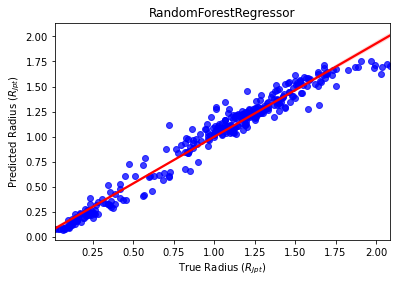

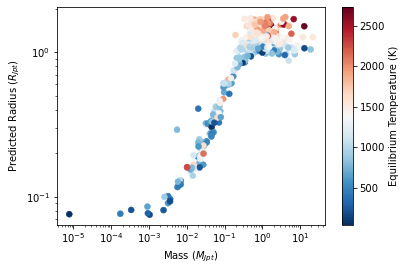

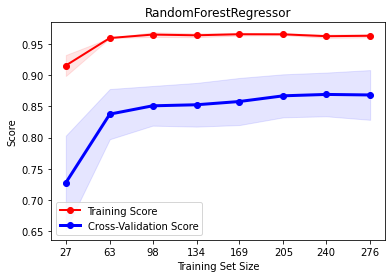

In [10]:
rf, RMSE_rf_val, cv_rf, r2_rf, RMSE_rf = random_forest_regressor(prepared_df, fit=True, scores=True, plot=True)

In [11]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=72, max_features=0.7000000000000001,
                      min_samples_split=9, n_estimators=117, random_state=1337)>

In [14]:
printScores(RMSE_rf_val, cv_rf, r2_rf, RMSE_rf)

Validation set RMSE: 0.11831678965173976
CV score: [0.72741087 0.83763961 0.85096202 0.85267119 0.85787955 0.86703195
 0.86923956 0.86839664]
Test set R2 score: 0.8558678741688177
Test set RMSE: 0.17862830252004075
